In [1]:
# %%time
## Just an easy way to load utility functions
dataset_name = "W19_only"
df_list = []

%matplotlib inline 
%run f2f_header.py {dataset_name} {df_list}

global BES_label_list, BES_df_list

# %run f2f_utility.py

BES_df_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_df_list.pickle", "rb" ) )
# f2f_harmonised = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised.zip", compression='zip')
BES_label_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_label_list.pickle", "rb" ) )
demo_var_dict = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\demo_var_dict.pickle", "rb" ) )
var_type_dict_nonans = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\var_type_dict_nonans.pickle", "rb" ) )

f2f_harmonised = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised_temp.zip", compression='zip')


generic_cols = f2f_harmonised.columns
list_of_scale_harm_vars = ["Age","year_past_min_sch_leave_age","in_school_past_min_age"]



## BUGS

BES_label_list["1959"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'
BES_label_list["1964"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'
BES_label_list["1966"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'
BES_label_list["1970"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'

BES_label_list["2015"]['edlevel'] = 'Education level (summary)'



Toggle code

In [125]:
ge_to_date_dict = {'1959':"8/10/1959", '1964':"15/10/1964", '1966':"31/3/1966", '1970':"18/6/1970", '1974_feb':"28/2/1974",
 '1974_oct':"10/10/1974", '1979':"5/3/1979", '1983':"9/6/1983",'1987':"11/6/1987", '1992':"9/4/1992",
 '1997':"1/5/1997", '2001':"7/6/2001", '2005':"5/5/2005", '2010':"6/5/2010", '2015':"7/5/2015",
 '2017':"8/6/2017", '2019':"12/12/2019"}

def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
#     raise Exception
    data.plot(x=x, y=y, yerr=yerr,xerr=None, kind="line", ax=ax, **kwargs)

def OLS_party_housing(variance_scaled = False, regularised=False, regression_type="OLS",const=True,
                     cols = ['age', 'inc_det', 'gender_complete', 'housing'],drop_first=True,dummy_na=False,
                     dummied_cols = None,
                     mask = f2f_harmonised["bloc_complete"].isin(["Left-Lib","Right-Auth"]),
                     target = "auth_right_vote",
                     error_bars=False, hide_const=False,add_actual=False,
                     ax=None,single_legend=False,eyeline=True,alpha_const_actual=True,
                     switch_ge_for_age=False):

    import statsmodels.api as sm
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    wt_var = "wt_norm"
    
    
#     mask = 
    if regression_type=="Weighted_OLS":
        mask = mask & f2f_harmonised[wt_var].notnull()
    if dummied_cols == None:
        dummied_cols = list(pd.get_dummies(f2f_harmonised[cols][mask],drop_first=drop_first,dummy_na=dummy_na).columns)

    if const:
        dummied_cols = ["const"]+dummied_cols
    if add_actual:
        dummied_cols = ["actual"]+dummied_cols
    results_df = pd.DataFrame(columns = dummied_cols)        
    # add error_bar columns
    if error_bars:
        dummied_errs = [x+'_err' for x in dummied_cols]
        results_df[dummied_errs]=np.nan
        
    scaler = StandardScaler()

    for ge in f2f_harmonised["dataset"].unique():
    # ge = "1979"
        df = f2f_harmonised[mask][f2f_harmonised["dataset"][mask]==ge][cols+[target]]
        if df.shape[0]==0:
            continue
        if regression_type == "Weighted_OLS":
            sample_weight = f2f_harmonised[mask][f2f_harmonised["dataset"][mask]==ge][wt_var]
#             raise Exception
        X = pd.get_dummies(df.drop([target],axis=1),drop_first=drop_first,dummy_na=dummy_na)
        X = X[intersection(X.columns, dummied_cols)]
        
        if variance_scaled:
            X = pd.DataFrame(scaler.fit_transform(X,sample_weight=sample_weight),columns=X.columns,index=X.index)
        if const:
            X = sm.add_constant(X)

        Y = df[target]
        if regression_type == "OLS":
            model = sm.OLS(Y,X)
        elif regression_type == "Logit":
            model = sm.Logit(Y,X)
        elif regression_type == "Probit":
            model = sm.Probit(Y,X)
        elif regression_type == "Weighted_OLS":
            if regularised:
                model = ElasticNet(fit_intercept=False,alpha=0.0)
#                 LinearRegression()
            else:
                model = LinearRegression(fit_intercept=False)
                
            model.fit(X, Y, sample_weight=sample_weight)
            
        ## switch ge for mean age!
        if switch_ge_for_age:
            ge = weighted_mean(zip( f2f_harmonised[mask][f2f_harmonised["dataset"][mask]==ge]["age"],f2f_harmonised[mask][f2f_harmonised["dataset"][mask]==ge][wt_var]  ))

        # results.params
        if regression_type == "Weighted_OLS":
            results_df.loc[ge,X.columns] = model.coef_
        else:
            if regularised:        
                results = model.fit_regularized()
            else:
                results = model.fit()            
            results_df.loc[ge,X.columns] = results.params.values
            
        # error bars
        # dodgy, grabbing only
        if error_bars:
            if regression_type == "Weighted_OLS":
                model = sm.OLS(Y,X)
            # otherwise use sm model used prior
            results = model.fit()
            errors = results.conf_int()
            results_df.loc[ge,[x+"_err" for x in X.columns]] = (results_df.loc[ge,X.columns]-errors[0]).values
#             raise Exception
        
        if add_actual:
            if regression_type == "Weighted_OLS":
                results_df.loc[ge,"actual"] = sum(Y.loc[X.dropna().index]*sample_weight.loc[X.dropna().index])/sum(sample_weight.loc[X.dropna().index])
#                 (Y.loc[X.dropna().index]*sample_weight.loc[X.dropna().index]).mean()
#                 results_df.loc[ge,"actual"] = Y.mean()
#                 raise Exception
            else:
                results_df.loc[ge,"actual"] = Y.loc[X.dropna().index].mean()

    results_df = results_df.sort_index()

#     else:
#         title = title+"_unscaled"        
#     results_df.plot(kind='line',title=title)  

    if ax is None:
        plt.figure(figsize=(12,6));
        ax=plt.gca()
        
#     if single_legend:
#         legend=False
#     else:
#         legend='auto'
    x_label = "UK GE Date"
    y_label = "Impact on Probability"
    hue_label = "Factor"
    title = 'Probability of Voting: '+target
#     if variance_scaled:
#         title = title+"_scaled"
# #     else:
# #         title = title+"_unscaled"
#     if regularised:
#         title = title+"_regularised"    
    hue_name_replace_dict = {"inc_norm_wt":"income(decile)",
                         "generation":"age(generation)",
                         "gender_complete":"gender(female)",
                         "housing_OWN":"tenure(OWN&MORT)","housing_RENT":"tenure(RENT)",
                         "housing_det_OWN":"tenure(OWN)","housing_det_MORT":"tenure(MORT)","housing_det_OWN-MORT":"tenure(OWN&MORT)",
                         "housing_det_RENT-LA":"tenure(RENT-LA)","housing_det_RENT-PR":"tenure(RENT-PR)","housing_det_RENT-HA":"tenure(RENT-HA)","housing_det_RENT-ALL":"tenure(RENT)",
                         "age_left_education_3_15 or younger":"left_edu(15-)","age_left_education_3_16":"left_edu(16)",
                         "age_left_education_3_18":"left_edu(17-18)","age_left_education_3_19 or older":"left_edu(19+)",
                        }
#     sns.set(font_scale = 2)
    if error_bars:
        res_df = results_df[dummied_cols].reset_index().melt(id_vars='index')
        if not switch_ge_for_age:
            res_df["index"] = res_df["index"].replace(ge_to_date_dict).apply(lambda x: pd.to_datetime(x))
        res_df.columns = [x_label,hue_label,y_label]
        res_df[y_label] = res_df[y_label.astype('float')]

#         err_df = results_df[dummied_errs].reset_index().melt(id_vars='index')
#         err_df["index"] = err_df["index"].replace(ge_to_date_dict).apply(lambda x: pd.to_datetime(x))
#         err_df.columns = [x_label,hue_label,y_label]
#         err_df[y_label] = err_df[y_label].astype('float')
        res_df["yerr"] = err_df[y_label]
        if hide_const:
            res_df = res_df.replace("const",np.nan).dropna()
#         res_df
        res_df=res_df.replace(hue_name_replace_dict)
        g = sns.FacetGrid(res_df, hue=hue_label,height=6,aspect=1.5)
        g.map_dataframe(errplot, x_label, y_label, "yerr",ax=ax)# test ax!
        g.add_legend()    
    
    else:
        

        res_df = results_df.reset_index().melt(id_vars='index')
        if not switch_ge_for_age:
            res_df["index"] = res_df["index"].replace(ge_to_date_dict).apply(lambda x: pd.to_datetime(x))
        res_df.columns = [x_label,hue_label,y_label]
        res_df[y_label] = res_df[y_label].astype('float')
        if hide_const:
            res_df = res_df.replace("const",np.nan).dropna()
        res_df=res_df.replace(hue_name_replace_dict)
        sns.lineplot(data = res_df,x=x_label,y=y_label,hue=hue_label,style=hue_label,markers=True,ax=ax);
        ax.set_xlabel(x_label,fontsize=16);
        ax.set_ylabel(y_label,fontsize=22);
        ax.set_title(title,fontsize=22);
#         plt.xticks(rotation=90);   
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if eyeline:
        ax.axhline(0, color ='grey', lw = 2, alpha=.2);
    if alpha_const_actual:
        if const or add_actual:
            ax.get_lines()[0].set_alpha(.5);   
        if const and add_actual:
            ax.get_lines()[1].set_alpha(.5);   

    if single_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        legend_data = (handles, labels)
    else:
        legend_data = None
    
    
    return res_df,legend_data

In [133]:
def plot_OLS_set(target_list, X_list, figsize=(16.5, 6),  sharey=True, regression_type="Weighted_OLS",regularised=False,
                 variance_scaled=False,drop_first=False,hide_const=False,add_actual=True,dummied_cols=None, single_legend=True,
                 switch_ge_for_age=False, mask = f2f_harmonised["vote_complete_simple"].notnull()&f2f_harmonised["wt"].notnull(),
                 suptitle = None
                ):
    fig, axs = plt.subplots(ncols=len(target_list),figsize=figsize, sharey=sharey);
    ax_pos = 0
    for target in target_list:
        df,(handles, labels)=OLS_party_housing(variance_scaled=variance_scaled,drop_first=drop_first,cols = X_list,
                    target=target,mask=mask,
                    regression_type=regression_type, regularised=regularised, hide_const=hide_const,add_actual=add_actual,
                    dummied_cols=dummied_cols,single_legend=single_legend,
                    ax=axs[ax_pos],switch_ge_for_age=switch_ge_for_age)
        ax_pos=ax_pos+1
    if single_legend:
#         handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, 
                   loc='upper center',
                   bbox_to_anchor=(0.5, 0.05), bbox_transform = plt.gcf().transFigure,
                   fancybox=False, shadow=False, ncol=5);
#         raise Exception
#     return (handles, labels)
    if suptitle:
        fig.suptitle(suptitle)

# mask = f2f_harmonised["vote_complete_simple"].notnull()&f2f_harmonised["wt"].notnull()

In [ ]:
# def plot_OLS_set_by_age(target_list, X_list, figsize=(16.5, 6),  sharey=True, regression_type="Weighted_OLS",regularised=False,
#                  variance_scaled=False,drop_first=False,hide_const=False,add_actual=True,dummied_cols=None, single_legend=True):
#     fig, axs = plt.subplots(ncols=len(target_list),figsize=figsize, sharey=sharey);
#     ax_pos = 0
#     for target in target_list:
#         df,(handles, labels)=OLS_party_housing(variance_scaled=variance_scaled,drop_first=drop_first,cols = X_list,
#                     target=target,mask = f2f_harmonised["vote_complete_simple"].notnull()&f2f_harmonised["wt"].notnull(),
#                     regression_type=regression_type, regularised=regularised, hide_const=hide_const,add_actual=add_actual,
#                     dummied_cols=dummied_cols,single_legend=single_legend,
#                     ax=axs[ax_pos],switch_ge_for_age=True)
#         ax_pos=ax_pos+1
#     if single_legend:
# #         handles, labels = axs[0].get_legend_handles_labels()
#         fig.legend(handles, labels, 
#                    loc='upper center',
#                    bbox_to_anchor=(0.5, 0.05), bbox_transform = plt.gcf().transFigure,
#                    fancybox=False, shadow=False, ncol=5);
# #         raise Exception
# #     return (handles, labels)

,inc_det,inc_norm,inc_norm_wt
inc_det,1.000000,0.928029,0.865011
inc_norm,0.928029,1.000000,0.951439
inc_norm_wt,0.865011,0.951439,1.000000


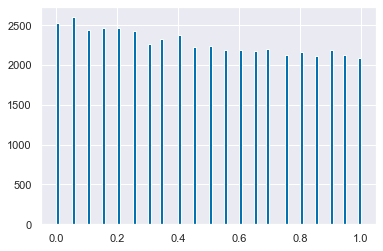

In [5]:
wt_means = f2f_harmonised.groupby("dataset")["wt"].mean().to_dict()
f2f_harmonised["wt_norm"] = f2f_harmonised.apply(lambda x: x["wt"]/wt_means[x["dataset"]] , axis=1 )

f2f_harmonised["AuthRight"] = f2f_harmonised["bloc_complete"]=="Right-Auth"
f2f_harmonised["LibLeft"] = f2f_harmonised["bloc_complete"]=="Left-Lib"

f2f_harmonised["CON"] = f2f_harmonised["vote_complete_simple"]=="CON"
f2f_harmonised["LAB"] = f2f_harmonised["vote_complete_simple"]=="LAB"
f2f_harmonised["DNV"] = f2f_harmonised["vote_complete_simple"]=="DNV"
f2f_harmonised["LD"]  = f2f_harmonised["vote_complete_simple"]=="LD"
f2f_harmonised["REFUK"]  = f2f_harmonised["vote_complete_simple"]=="REFUK"
f2f_harmonised["SNP"]  = f2f_harmonised["vote_complete_simple"]=="SNP"
f2f_harmonised["GP"]  = f2f_harmonised["vote_complete_simple"]=="GP"
f2f_harmonised["DK"]  = f2f_harmonised["vote_complete_simple"]=="DK"
f2f_harmonised["PC"]  = f2f_harmonised["vote_complete_simple"]=="PC"
f2f_harmonised["decade"] = f2f_harmonised["age"]/10
f2f_harmonised["generation"] = f2f_harmonised["age"]/20
inc_maxes = f2f_harmonised.groupby("dataset")["inc_det"].max().to_dict()
f2f_harmonised["inc_norm"] = f2f_harmonised.apply(lambda x: x["inc_det"]/inc_maxes[x["dataset"]] , axis=1 )#.groupby(f2f_harmonised["dataset"]).hist()
## do a proper version with weighting/quantiles

f2f_harmonised["inc_norm_wt"]=np.nan
temp = (f2f_harmonised[f2f_harmonised["wt"].notnull()].groupby("dataset").apply(lambda x: weighted_qcut(x["inc_det"],x["wt"],21)).cat.codes/20)
reverse_dict = {v:k for k,v in f2f_harmonised[f2f_harmonised["wt"].notnull()].groupby("dataset").apply(lambda x: x["uid"]).to_dict().items()}
f2f_harmonised.loc[f2f_harmonised["wt"].notnull(),"inc_norm_wt"]=temp.loc[f2f_harmonised["uid"][f2f_harmonised["wt"].notnull()].apply(lambda x: reverse_dict[x])].values
# weighted_qcut

f2f_harmonised["inc(quartile)"] = f2f_harmonised["inc_norm_wt"]*4
f2f_harmonised["inc_norm_wt"].hist(bins=100)
f2f_harmonised[["inc_det","inc_norm","inc_norm_wt"]].corr()


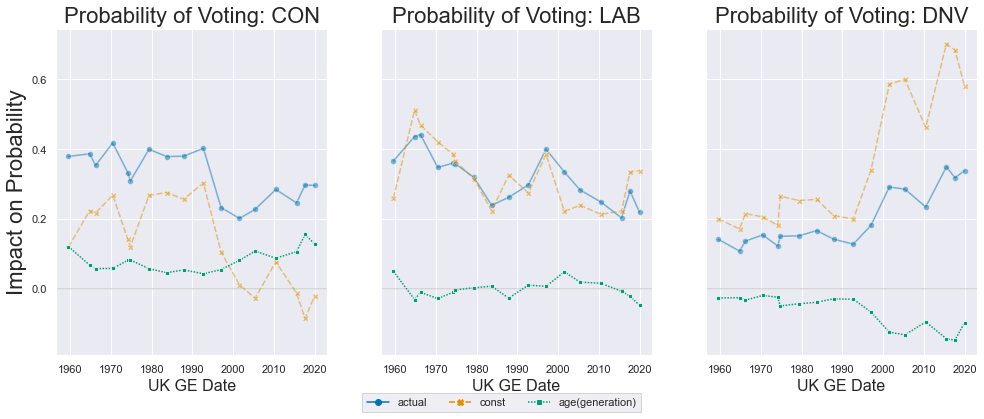

In [6]:
plot_OLS_set(["CON","LAB","DNV"], ["generation"], figsize=(16.5, 6),  sharey=True)

In [68]:
# Baby boomers are the people born following World War II from 1946 to 1964
wt_mask = (f2f_harmonised["wt"].notnull())

Z_mask = (f2f_harmonised["birth_year"] >= 1997) & (f2f_harmonised["birth_year"] <= 2012) & wt_mask
millenial_mask = (f2f_harmonised["birth_year"] >= 1981) & (f2f_harmonised["birth_year"] <= 1996) & wt_mask
X_mask = (f2f_harmonised["birth_year"] >= 1965) & (f2f_harmonised["birth_year"] <= 1980) & wt_mask
boomer_mask = (f2f_harmonised["birth_year"] >= 1946) & (f2f_harmonised["birth_year"] <= 1964) & wt_mask
silent_mask = (f2f_harmonised["birth_year"] >= 1928) & (f2f_harmonised["birth_year"] <= 1945) & wt_mask
greatest_mask = (f2f_harmonised["birth_year"] >= 1901) & (f2f_harmonised["birth_year"] <= 1927) & wt_mask

In [70]:
Z = f2f_harmonised[Z_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
millenial = f2f_harmonised[millenial_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
X = f2f_harmonised[X_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
boomer = f2f_harmonised[boomer_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
silent = f2f_harmonised[silent_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
greatest = f2f_harmonised[greatest_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
# boomer = f2f_harmonised[birth_year_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))

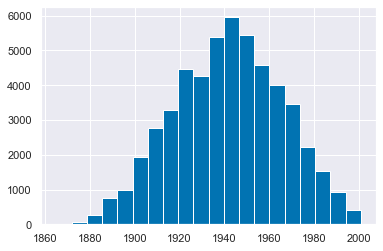

In [39]:
f2f_harmonised["birth_year"].hist(bins=20)

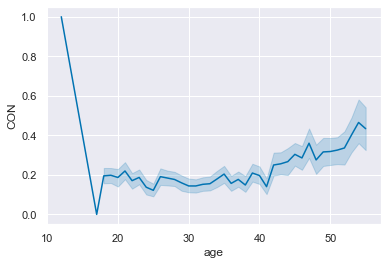

In [21]:
sns.lineplot(data = f2f_harmonised[birth_year_mask],x='age',y="CON")

In [106]:
def get_generation(x):
    if (x>=1997) & (x<=2012):
        return "Gen Z"
    elif (x>=1981) & (x<=1996):
        return "Millenial"
    elif (x>=1965) & (x<=1980):
        return "Gen X"
    elif (x>=1946) & (x<=1964):
        return "Boomer"
    elif (x>=1928) & (x<=1945):
        return "Silent"
    elif (x>=1901) & (x<=1927):
        return "Greatest"
    elif (x>=1883) & (x<=1900):
        return "Lost"
    elif x<=1882:
        return "Pre"
    elif x>=2013:
        return "Post"

f2f_harmonised["generation"] = f2f_harmonised["birth_year"].apply(lambda x: get_generation(x))
f2f_harmonised["generation"] = f2f_harmonised["generation"].astype('category').cat.reorder_categories(['Pre', 'Lost', 'Greatest', 'Silent', 'Boomer', 'Gen X', 'Millenial', 'Gen Z', ], ordered=True)
f2f_harmonised["generation"]

index
0       Millenial
1           Gen X
2       Millenial
3           Gen Z
4       Millenial
          ...    
2917       Silent
2918       Silent
2919       Boomer
2920       Silent
2921       Silent
Name: generation, Length: 52731, dtype: category
Categories (8, object): ['Pre' < 'Lost' < 'Greatest' < 'Silent' < 'Boomer' < 'Gen X' < 'Millenial' < 'Gen Z']

In [ ]:
Z = f2f_harmonised[Z_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
millenial = f2f_harmonised[millenial_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
X = f2f_harmonised[X_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
boomer = f2f_harmonised[boomer_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
silent = f2f_harmonised[silent_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
greatest = f2f_harmonised[greatest_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))
# boomer = f2f_harmonised[birth_year_mask].groupby("dataset").apply(lambda x: weighted_mean(zip(x["CON"],x["wt_norm"])  ))

In [45]:
f2f_harmonised[birth_year_mask].groupby("dataset").apply(lambda x: sum(x["wt"].dropna())  )

dataset
1959           5.000000
1966           4.000000
1974_feb     449.000000
1974_oct     492.000000
1979         556.000000
1983        1473.740000
1987        1414.083000
1992        1083.360000
1997        1009.685150
2001         975.441027
2005        1371.337525
2010         929.951219
2015         837.706912
2017         613.214693
2019        1018.251099
dtype: float64

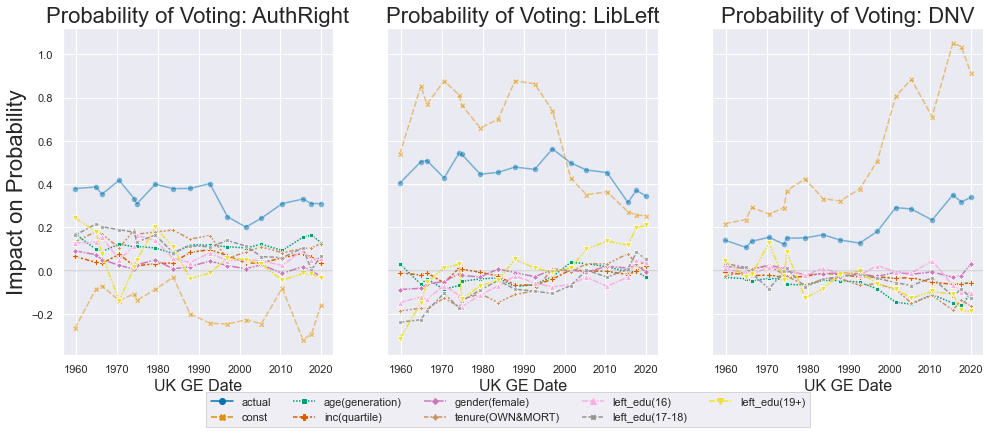

In [75]:
plot_OLS_set(["AuthRight","LibLeft","DNV"], ["generation","inc(quartile)","gender_complete","housing","age_left_education_3"],
             dummied_cols=["generation","inc(quartile)","gender_complete","housing_OWN","age_left_education_3_16","age_left_education_3_18",
                          "age_left_education_3_19 or older"],
             drop_first=False, figsize=(16.5, 6),  sharey=True, )

Greatest
Silent
Boomer
Gen X
Millenial
Gen Z


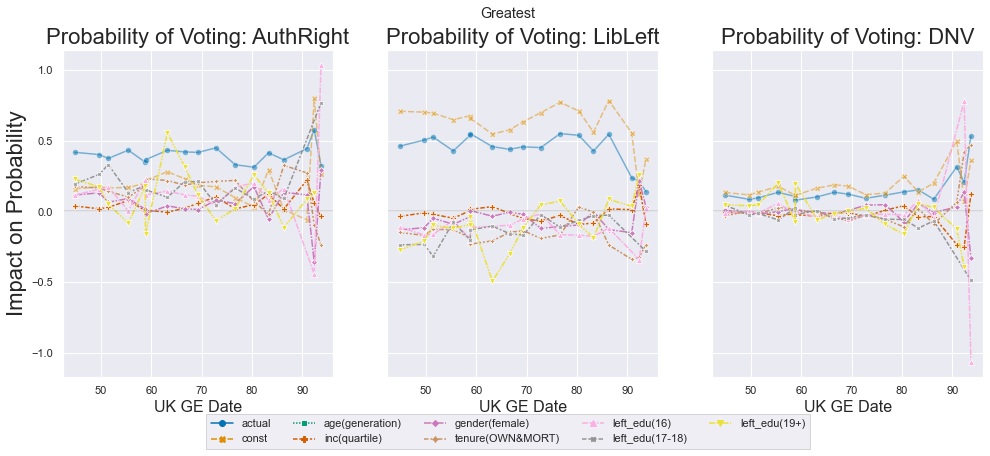

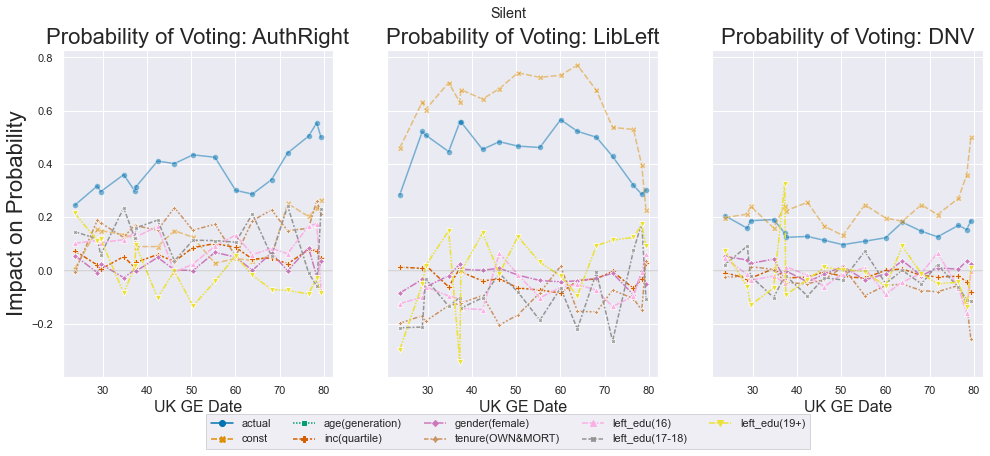

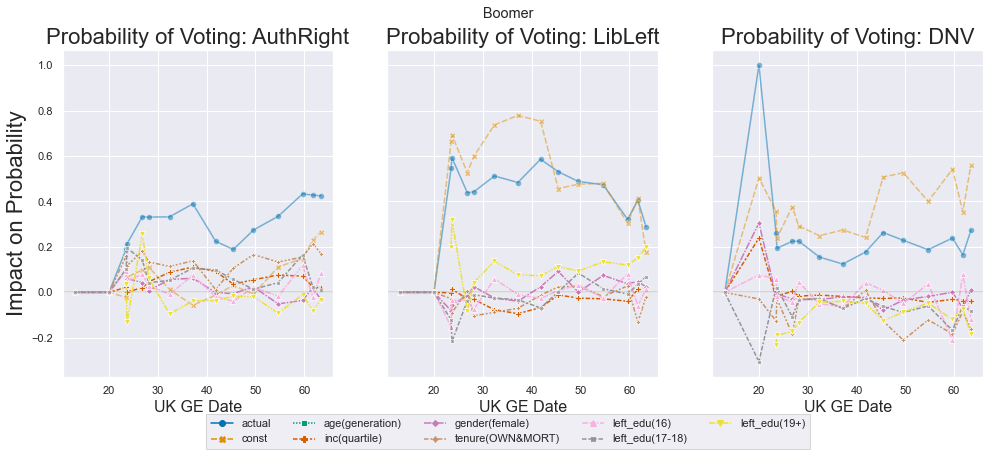

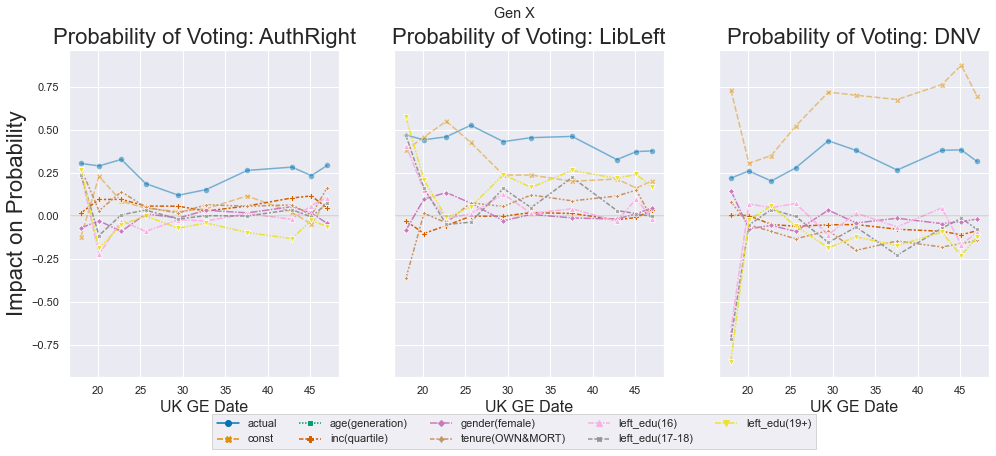

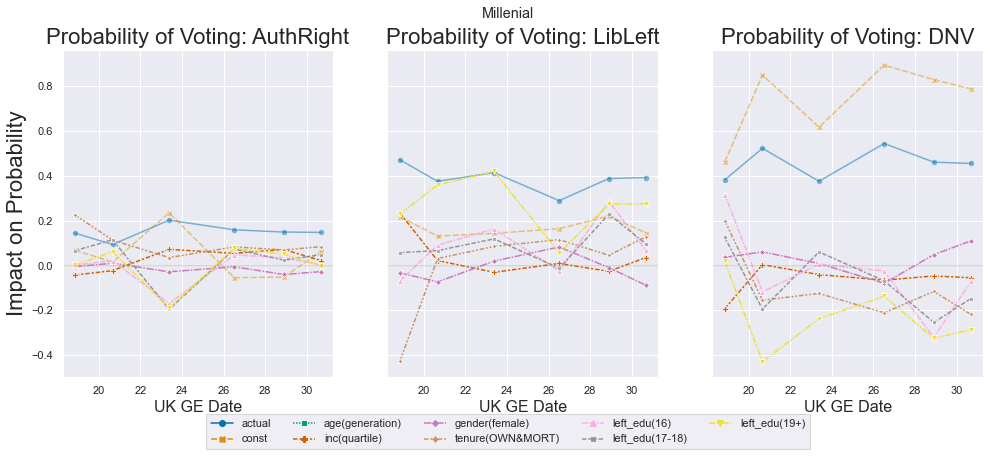

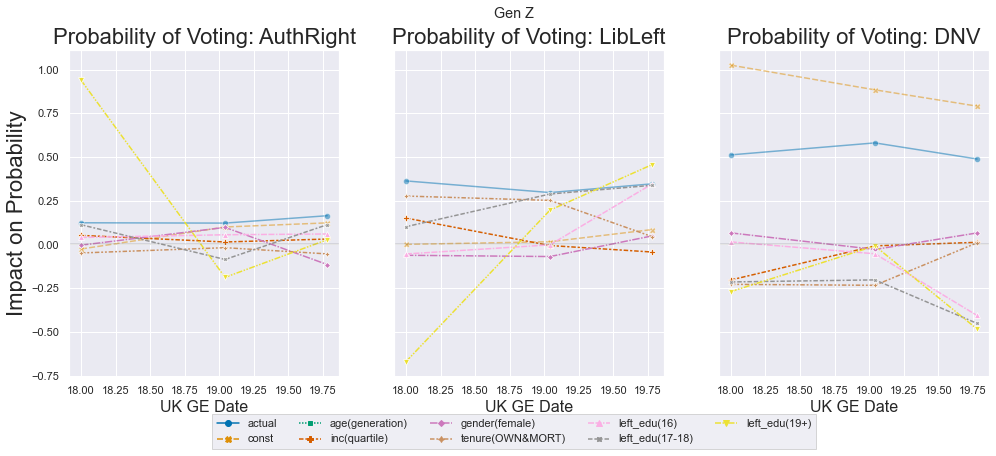

In [134]:
for gen in ['Greatest', 'Silent', 'Boomer', 'Gen X', 'Millenial', 'Gen Z']:

# ['Pre', 'Lost', 'Greatest', 'Silent', 'Boomer', 'Gen X', 'Millenial', 'Gen Z']:
    print(gen)

    plot_OLS_set(["AuthRight","LibLeft","DNV"], ["generation","inc(quartile)","gender_complete","housing","age_left_education_3"],
             dummied_cols=["inc(quartile)","gender_complete","housing_OWN","age_left_education_3_16","age_left_education_3_18",
                          "age_left_education_3_19 or older"],
             drop_first=False, figsize=(16.5, 6),  sharey=True, switch_ge_for_age=True,
             mask = f2f_harmonised["vote_complete_simple"].notnull()&f2f_harmonised["wt"].notnull()& (f2f_harmonised["generation"]==gen ),
             suptitle = gen,
                        )

In [137]:
values = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised_values.zip", compression='zip')

In [139]:
f2f_harmonised[values.columns]=values

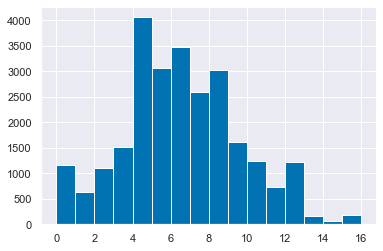

In [143]:
f2f_harmonised["ec_left_right"].hist(bins=16)

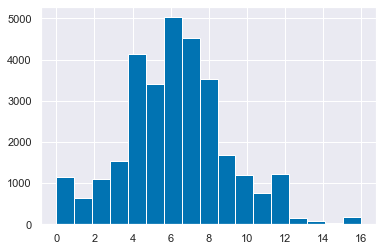

In [149]:
f2f_harmonised["ec_left_right_complete"].hist(bins=17)

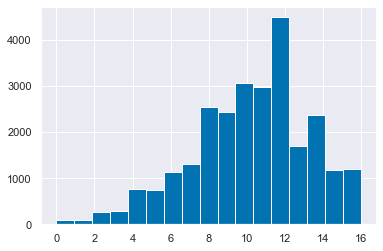

In [148]:
f2f_harmonised["soc_lib_auth"].hist(bins=17)

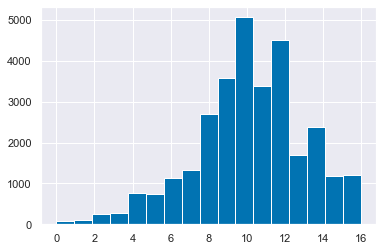

In [150]:
f2f_harmonised["soc_lib_auth_complete"].hist(bins=17)

In [155]:
f2f_harmonised["ec_left_right_complete"].value_counts().sort_index()

0.000000     1160
1.000000      545
1.333333       92
1.456564        1
2.000000      983
             ... 
13.333333       7
14.000000      72
14.666667       2
15.000000      19
16.000000     166
Name: ec_left_right_complete, Length: 4533, dtype: int64

In [156]:
f2f_harmonised["soc_lib_auth_complete"].value_counts().sort_index()

0.000000       88
1.000000       62
1.333333       35
2.000000      207
2.666667       57
             ... 
13.333333     537
14.000000    1835
14.666667     378
15.000000     797
16.000000    1197
Name: soc_lib_auth_complete, Length: 3769, dtype: int64

In [157]:
f2f_harmonised["ec_left_right_complete"] = f2f_harmonised["ec_left_right_complete"]/16
f2f_harmonised["soc_lib_auth_complete"]  = f2f_harmonised["soc_lib_auth_complete"]/16

Greatest
Silent
Boomer
Gen X
Millenial
Gen Z


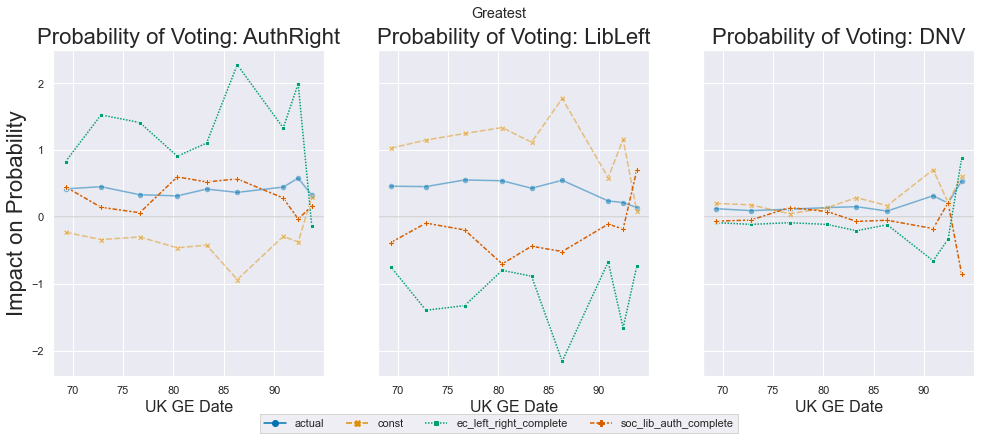

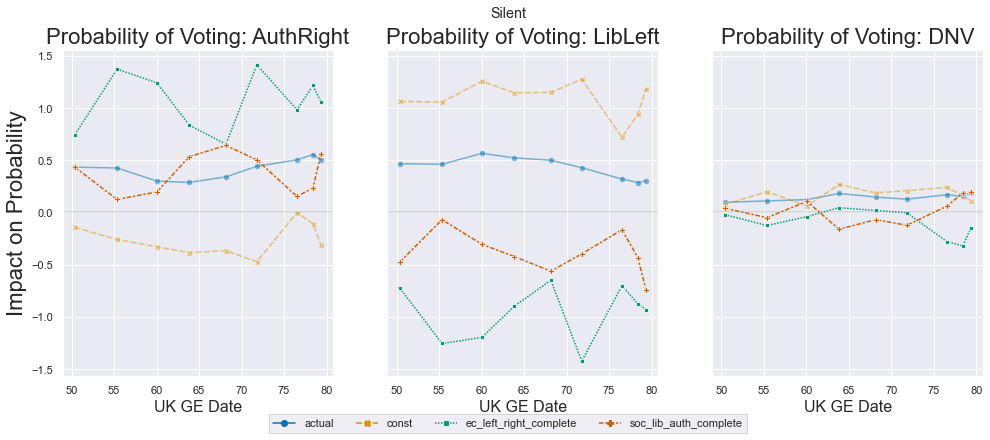

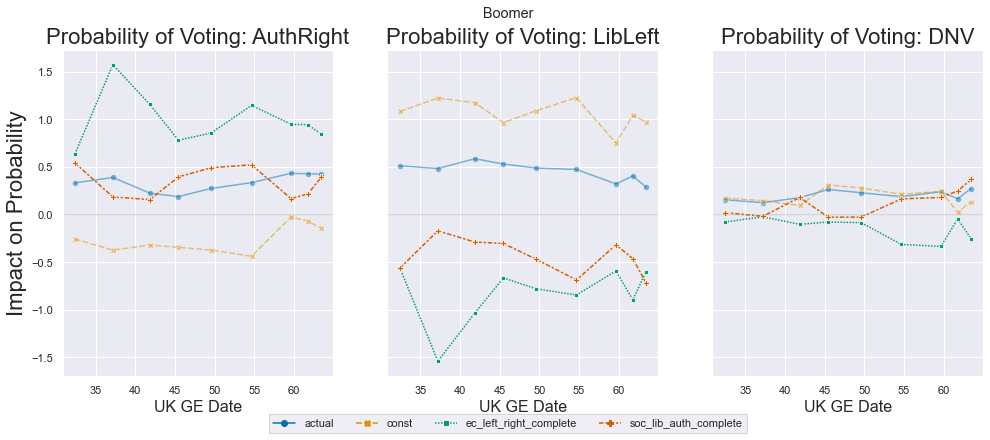

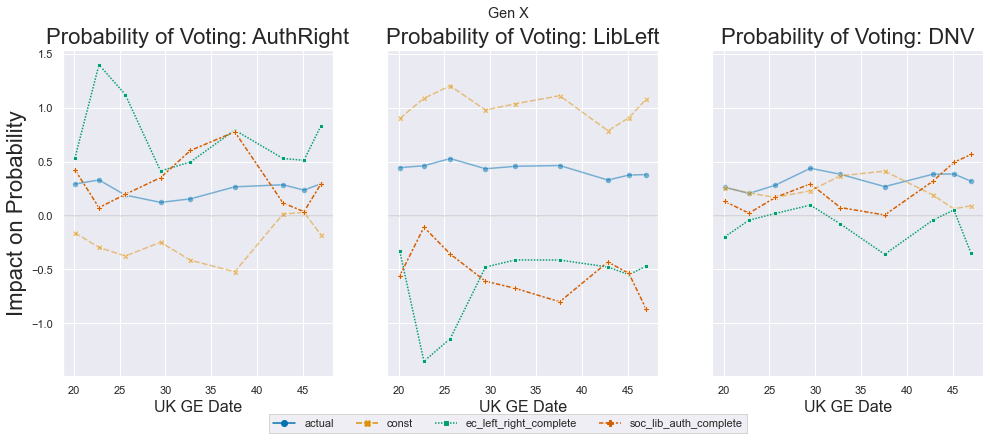

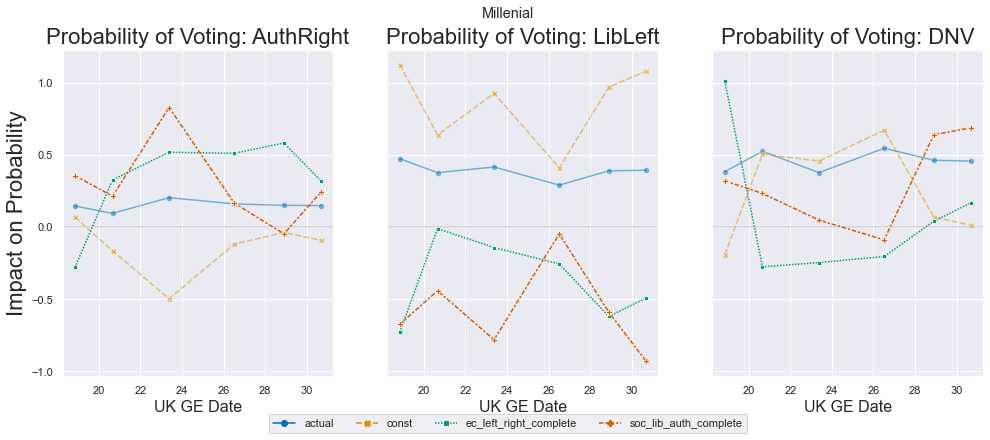

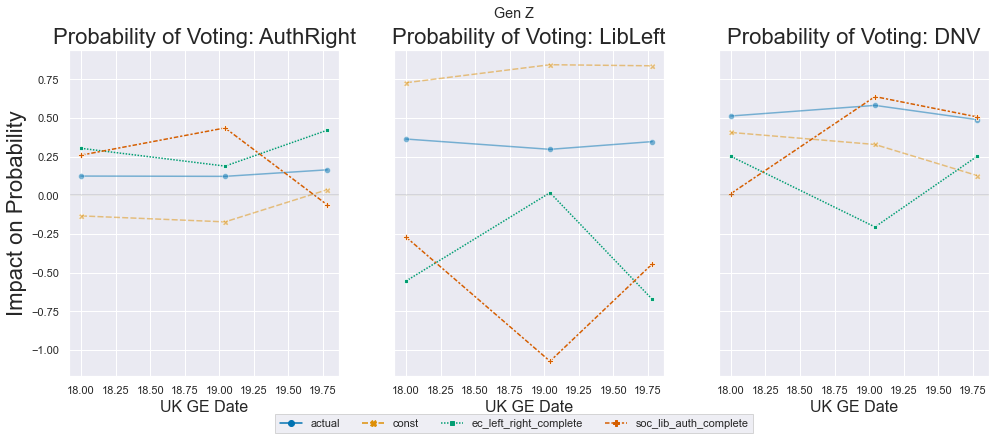

In [158]:
for gen in ['Greatest', 'Silent', 'Boomer', 'Gen X', 'Millenial', 'Gen Z']:

# ['Pre', 'Lost', 'Greatest', 'Silent', 'Boomer', 'Gen X', 'Millenial', 'Gen Z']:
    print(gen)

    plot_OLS_set(["AuthRight","LibLeft","DNV"],
                 ["ec_left_right_complete","soc_lib_auth_complete"],
             dummied_cols=["ec_left_right_complete",
                          "soc_lib_auth_complete"],
             drop_first=False, figsize=(16.5, 6),  sharey=True, switch_ge_for_age=True,
             mask = f2f_harmonised["vote_complete_simple"].notnull() \
                     & (f2f_harmonised["wt"].notnull()) \
                     & (f2f_harmonised["generation"]==gen ) \
                     & (f2f_harmonised["ec_left_right_complete"].notnull()) \
                     & (f2f_harmonised["soc_lib_auth_complete"].notnull())
                 ,
             suptitle = gen,
                        )

Greatest
Silent
Boomer
Gen X
Millenial
Gen Z


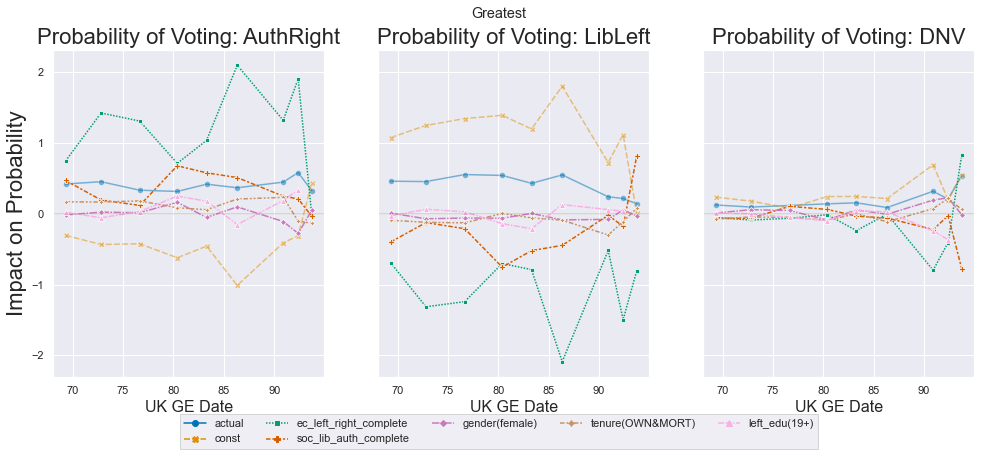

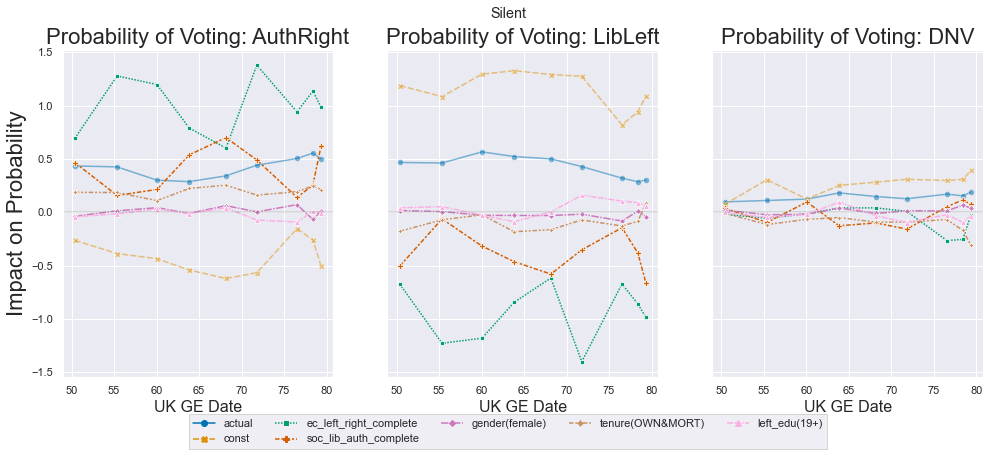

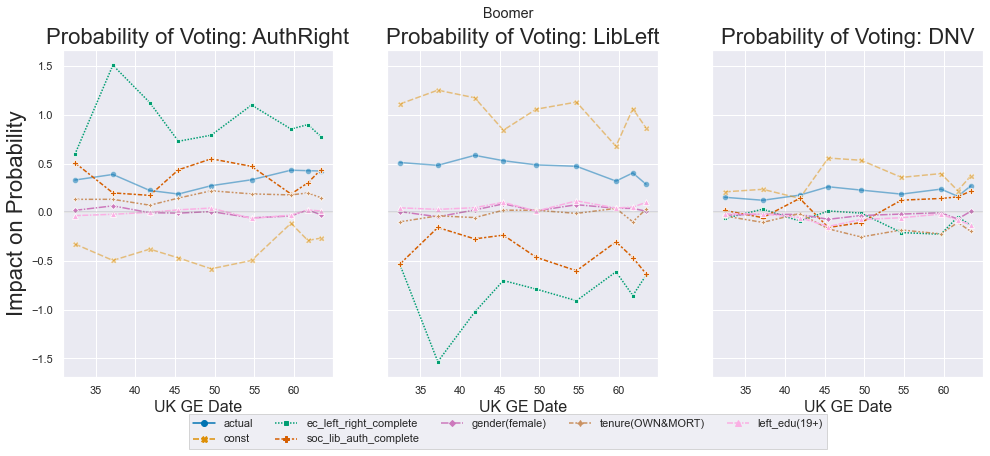

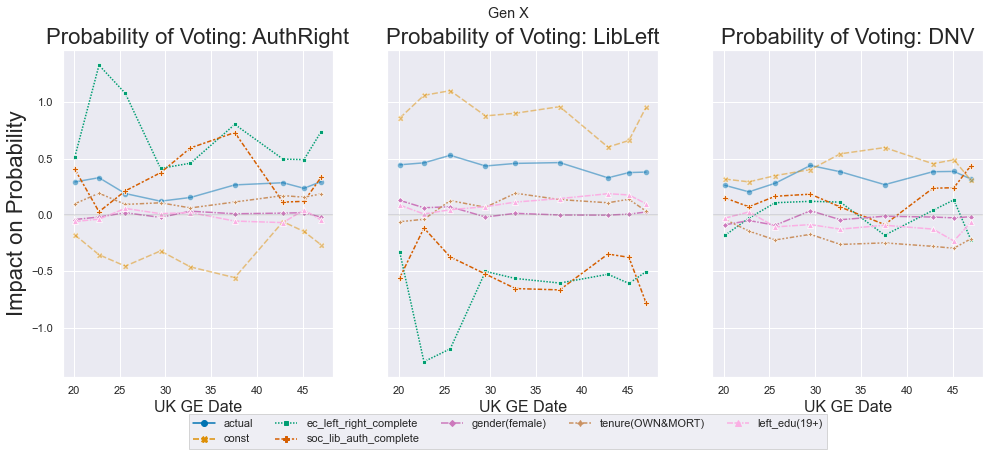

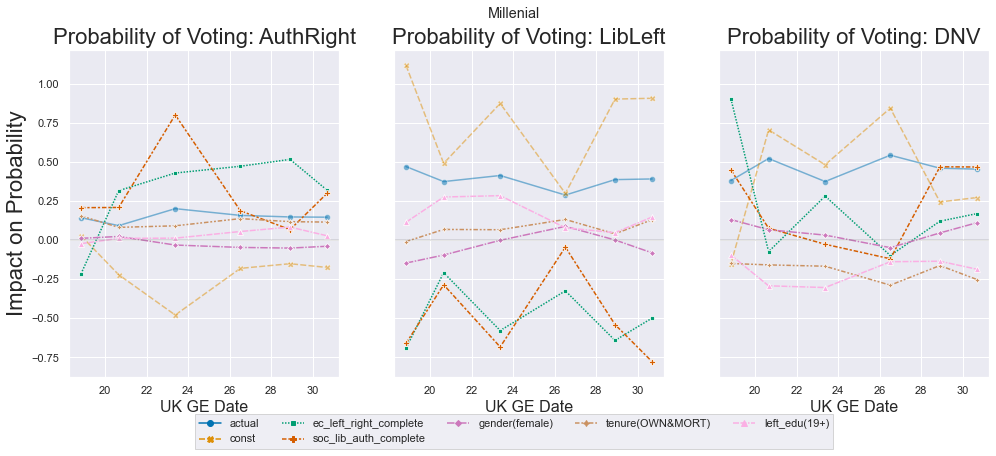

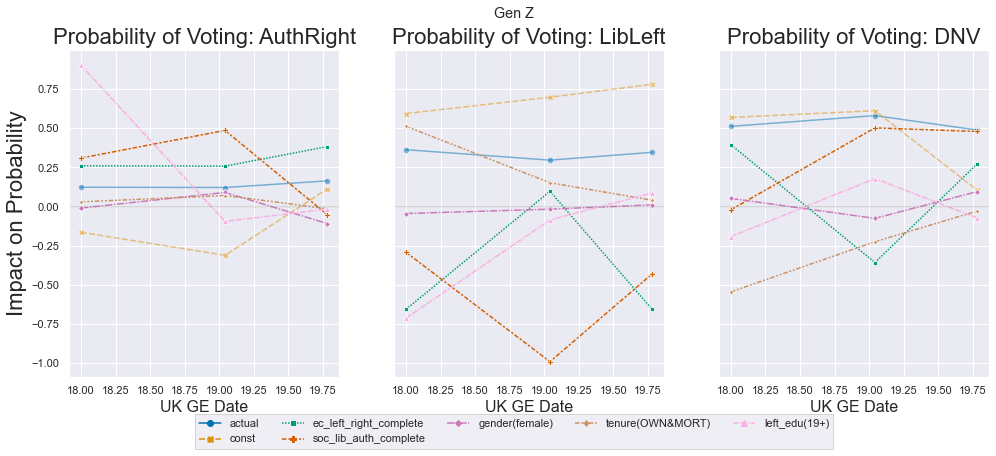

In [164]:
for gen in ['Greatest', 'Silent', 'Boomer', 'Gen X', 'Millenial', 'Gen Z']:

# ['Pre', 'Lost', 'Greatest', 'Silent', 'Boomer', 'Gen X', 'Millenial', 'Gen Z']:
    print(gen)

    plot_OLS_set(["AuthRight","LibLeft","DNV"],
                 ["ec_left_right_complete","soc_lib_auth_complete","inc(quartile)","gender_complete","housing","age_left_education_3"],
             dummied_cols=["ec_left_right_complete",
                          "soc_lib_auth_complete","gender_complete","housing_OWN",
                          "age_left_education_3_19 or older"],
             drop_first=False, figsize=(16.5, 6),  sharey=True, switch_ge_for_age=True,
             mask = f2f_harmonised["vote_complete_simple"].notnull() \
                     & (f2f_harmonised["wt"].notnull()) \
                     & (f2f_harmonised["generation"]==gen ) \
                     & (f2f_harmonised["ec_left_right_complete"].notnull()) \
                     & (f2f_harmonised["soc_lib_auth_complete"].notnull())
                 ,
             suptitle = gen,
                        )

In [ ]:
#  ["generation","inc(quartile)","gender_complete","housing","age_left_education_3"],
#              dummied_cols=["inc(quartile)","gender_complete","housing_OWN","age_left_education_3_16","age_left_education_3_18",
#                           "age_left_education_3_19 or older"],

In [163]:
# f2f_harmonised.columns[0:50]

Index(['dataset', 'uid', 'housing_det', 'housing', 'inc', 'vote', 'year', 'wt',
       'age', 'vote_simple', 'bloc', 'birth_year', 'harmonised_voted',
       'inc_det', 'vote_complete', 'vote_complete_simple', 'bloc_complete',
       'turnout_complete', 'gender', 'gender_complete', 'age_left_education',
       'age_left_education_2', 'age_left_education_3', 'anyQuals',
       'rsa_or_city_and_guilds', 'overseas_other_postschl', 'overseas_degree',
       'other_academic_vocational', 'other_tech_business',
       'higher_onc_ond_bec_tec', 'ordinary_gen_onc_ond_bec_tec',
       'trade_appenticeship', 'nursing', 'teachers_training',
       'city_and_guilds_cert_part1', 'city_and_guilds_full_tech',
       'city_and_guilds_advanced_final', 'city_and_guilds_craft_ordinary',
       'rsa_other_commercial', 'school_cert_or_matric',
       'uni_cnaa_degree_or_diploma', 'os_schl_leav_qual',
       'a_level_scot_higher', 'cse_grade_1_scot_lower', 'cse_grade_2_5',
       'professional_qualification'